In [18]:
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install deskew

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install opencv-python
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 36.7 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.1
    Uninstalling imageio-2.25.1:
      Successfully uninstalled imageio-2.25.1
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import cv2 # this is opencv module
from glob import glob

import os
import numpy as np
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pytesseract
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14,8]

import warnings
warnings.filterwarnings('ignore')


# 1. Preprocessing


In [8]:
image = cv2.imread(r"/content/drive/MyDrive/Data Train for BDC 2023 - Penyisihan/DataTrain171.png", 1)

In [9]:
bigger = cv2.resize(image, (256, 256))

In [10]:
image2 = cv2.imread(r"/content/drive/MyDrive/Data Train for BDC 2023 - Penyisihan/DataTrain120.png",1)

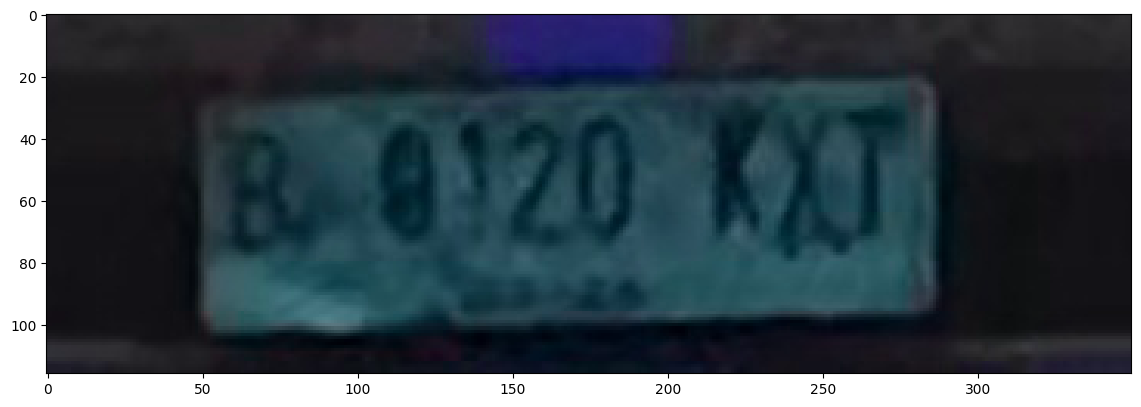

In [11]:
plt.imshow(image)

In [12]:
train = pd.read_csv("/content/drive/MyDrive/Data csv train/DataTrain.csv")
test = pd.read_csv("/content/drive/MyDrive/Data Test for BDC 2023 - Penyisihan/DataTest.csv")


In [13]:
path = glob('/content/drive/MyDrive/Data Train for BDC 2023 - Penyisihan/*.png')
train['path'] = path
path1 = glob("/content/drive/MyDrive/Data Test for BDC 2023 - Penyisihan/*.png")
test['path'] = path1

In [27]:
from pandas.core.generic import Frequency
def imgtoarr(img):
  img = img_to_array(img)
  return img
def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask
def  deskew_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def remove_noise(image):
    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
    return cv2.GaussianBlur(image,(5,5),1)
def Edge_detection(image):
    return cv2.Canny(image,50,50)
def thresholding(image):
    return cv2.threshold(image, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 2)
def erode(image):
    kernel = np.ones((2,2),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)
def opening(image):
    kernel = np.ones((2,2),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
def canny(image):
    return cv2.Canny(image, 75, 200)


def sharpening(img):
    kernel_sharpening = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]])
    return cv2.filter2D(img,-1,kernel_sharpening)
def resize(img):
  height,width = img.shape
  # scale up the image when it is too small, using best method for word recognition
  if (height < 200 or width < 200) and (height > 100 or width > 100):
      print("scale up the image using 3x")
      img = cv2.resize(img, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
      plt.figure(figsize=(20,30))
      plt.imshow(img, cmap='gray')
      plt.axis('on')
      plt.show()

  elif (height < 100 or width < 100):
    print("scale up the image using 5x")
    img = cv2.resize(img, None, fx=5, fy=5, interpolation=cv2.INTER_CUBIC)
    plt.figure(figsize=(20,30))
    plt.imshow(img, cmap='gray')
    plt.axis('on')
    plt.show()

  else:
    plt.figure(figsize=(20,30))
    plt.imshow(img, cmap='gray')
    plt.axis('on')
    plt.show()
  return img
def bilateral(img):
  return cv2.bilateralFilter(img, 9, 75, 75)
def morph(img):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
  morph = cv2.morphologyEx(thresholding(img), cv2.MORPH_CLOSE, kernel)
  morph = cv2.bitwise_not(img)
  return morph



In [92]:
def structuring(img):
  structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))

  imgTopHat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, structuringElement)
  imgBlackHat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, structuringElement)

  imgGrayscalePlusTopHat = cv2.add(img, imgTopHat)
  img = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
  return img
def denoise(img):
  return cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
def gaussian(img):
  img_blur = cv2.GaussianBlur(img, (5,5), 0)
  img_tresh = cv2.adaptiveThreshold(
    img_blur,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    blockSize=519,
    C=21
    )
  return img_tresh
def bitwise(img):
  return cv2.bitwise_not(img)
def contour(img):
  contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  img_contours = np.zeros(img.shape)
  cv2.drawContours(img_contours, contours, -1, (255,255,255), 3, cv2.LINE_AA, None, 1)

  plt.figure(figsize=(20,30))
  plt.imshow(img_contours, cmap='gray')
  plt.axis('on')
  plt.show()
  temp_result = np.zeros(img.shape, dtype=np.uint8)
  contours_dict = []

  for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      cv2.rectangle(temp_result, (x,y), (x+w, y+h), (255,255,255), thickness=2)
      contours_dict.append({
          'x': x,
          'y': y,
          'w': w,
          'h': h,
          'cx': x + w/2,
          'cy': y + h/2
          })

  plt.figure(figsize=(20,30))
  plt.imshow(temp_result, cmap='gray')
  plt.axis('on')
  plt.show()

  MIN_AREA = 100
  MIN_WIDTH, MIN_HEIGHT = 1, 9
  MIN_RATIO, MAX_RATIO = 0.1, 5.0

  possible_contours = []
  cnt = 0

  for d in contours_dict:
      area = d['w'] * d['h']
      ratio = d['w'] / d['h']
      if area > MIN_AREA \
      and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
      and MIN_RATIO < ratio < MAX_RATIO:
          d['idx'] = cnt
          cnt += 1
          possible_contours.append(d)

  temp_result = np.zeros(img.shape, dtype=np.uint8)

  for d in possible_contours:
      # draw rectangle
      temp_result = cv2.rectangle(temp_result, (d['x'],d['y']), (d['x']+d['w'],d['y']+d['h']), (255,255,255), thickness=2)

  plt.figure(figsize=(20,30))
  plt.imshow(temp_result, cmap='gray')
  plt.axis('on')
  plt.show()
  MAX_DIAG_MULTIPLYER = 8 # 5
  MAX_ANGLE_DIFF = 15.0 # 12.0
  MAX_AREA_DIFF = 0.9 # 0.5
  MAX_WIDTH_DIFF = 1.5 # 0.8
  MAX_HEIGHT_DIFF = 0.6 # 0.2
  MIN_N_MATCHED = 5 # 3

  def find_chars(contour_list):
      matched_result_idx = []
      for d1 in contour_list:
          matched_contours_idx = []
          for d2 in contour_list:
              if d1['idx'] == d2['idx']:
                  continue

              dx = abs(d1['cx'] - d2['cx'])
              dy = abs(d1['cy'] - d2['cy'])

              diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

              distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'],d2['cy']]))
              if dx == 0:
                  angle_diff = 90
              else:
                  angle_diff = np.degrees(np.arctan(dy / dx))
              area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
              width_diff = abs(d1['w'] - d2['w']) / d1['w']
              height_diff = abs(d1['h'] - d2['h']) / d1['h']

              if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
              and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
              and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                  matched_contours_idx.append(d2['idx'])

        # append this contour
          matched_contours_idx.append(d1['idx'])

          if len(matched_contours_idx) < MIN_N_MATCHED:
              continue

          matched_result_idx.append(matched_contours_idx)

          unmatched_contour_idx = []
          for d4 in contour_list:
              if d4['idx'] not in matched_contours_idx:
                  unmatched_contour_idx.append(d4['idx'])

          unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

         # recursive
          recursive_contour_list = find_chars(unmatched_contour)

          for idx in recursive_contour_list:
              matched_result_idx.append(idx)

          break

      return matched_result_idx

  result_idx = find_chars(possible_contours)

  matched_result = []

  for idx_list in result_idx:
     matched_result.append(np.take(possible_contours, idx_list))

  temp_result = np.zeros(img.shape, dtype=np.uint8)

  for r in matched_result:
      for d in r:
         # draw rectangle
          temp_result = cv2.rectangle(temp_result, (d['x'],d['y']), (d['x']+d['w'],d['y']+d['h']), (255,255,255), thickness=2)

  plt.figure(figsize=(20,30))
  plt.imshow(temp_result, cmap='gray')
  plt.axis('on')
  plt.show()
  mask = np.zeros(img.shape, dtype=np.uint8)
  new_contours = []

  for r in matched_result:
      for d in r:
          new_contours.append(d)

  for d in new_contours:
      # draw rectangle
      mask = cv2.rectangle(mask, (d['x'],d['y']), (d['x']+d['w'],d['y']+d['h']), (255,255,255), thickness=-1)

  plt.figure(figsize=(20,30))
  plt.imshow(mask, cmap='gray')
  plt.axis('on')
  plt.show()

# keep only the plate
  copy_img = np.copy(img)
  copy_img[mask == 0] = 0

  plt.figure(figsize=(20,30))
  plt.imshow(copy_img, cmap='gray')
  plt.axis('on')
  plt.show()

# crop the plate based on the top left and bottom right corner of the plate using the real image
# get the top left and bottom right corner of the plate
  x, y, w, h = cv2.boundingRect(mask)
  img = img[y:y+h, x:x+w]

  plt.figure(figsize=(20,30))
  plt.imshow(img, cmap='gray')
  plt.axis('on')
  plt.show()
  return img
def puter(img):
  from deskew import determine_skew
  from scipy import ndimage

  # determine skew angle of the image
  angle = determine_skew(img)
  print("angle is {}".format(angle))

  # rotate the image to deskew it
  img = ndimage.rotate(img, angle, mode='constant', cval=255)
  return img

In [16]:
from skimage.filters import try_all_threshold


def thr(img):

  fig, ax = try_all_threshold(test, figsize=(10, 8), verbose=False)
  plt.show()

scale up the image using 3x


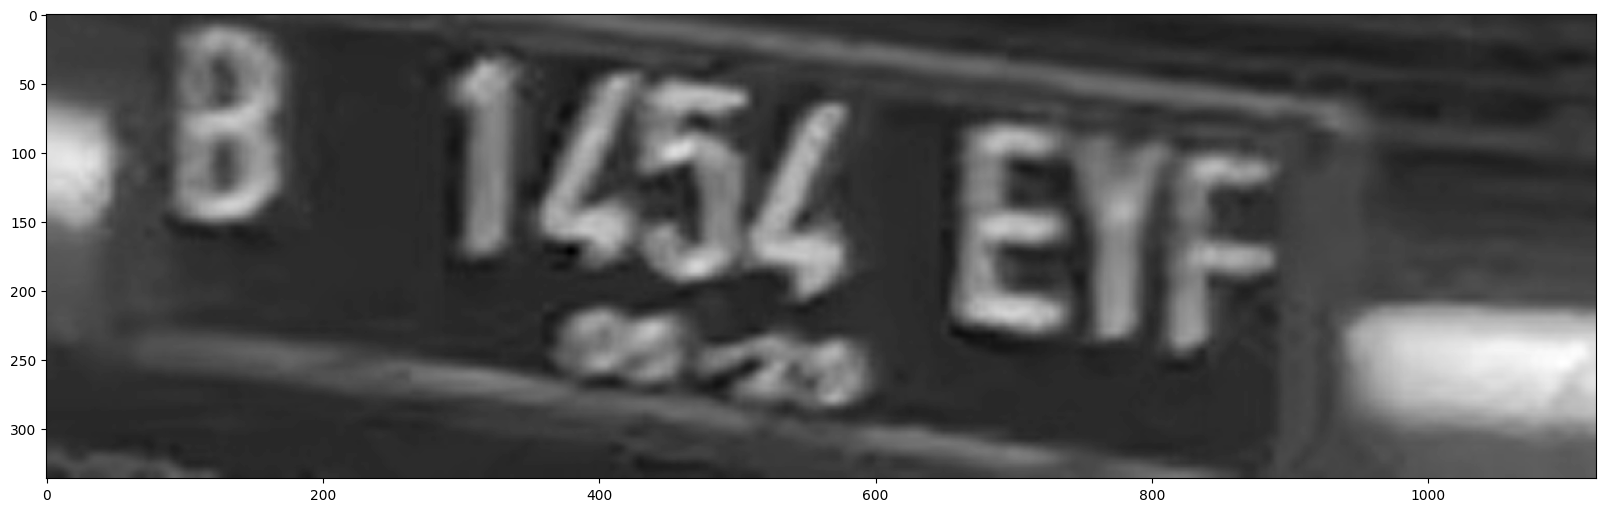

angle is 7.999999999999998


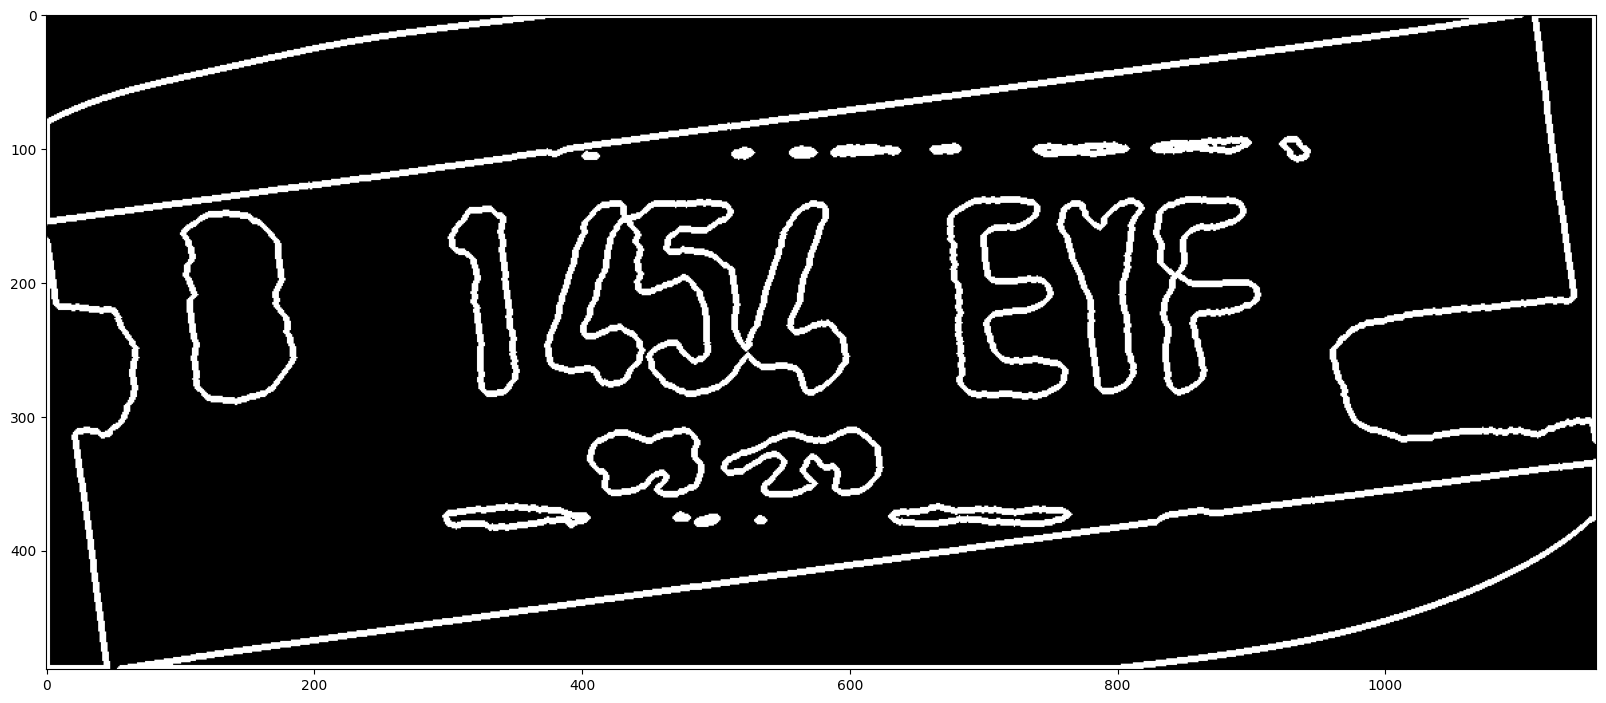

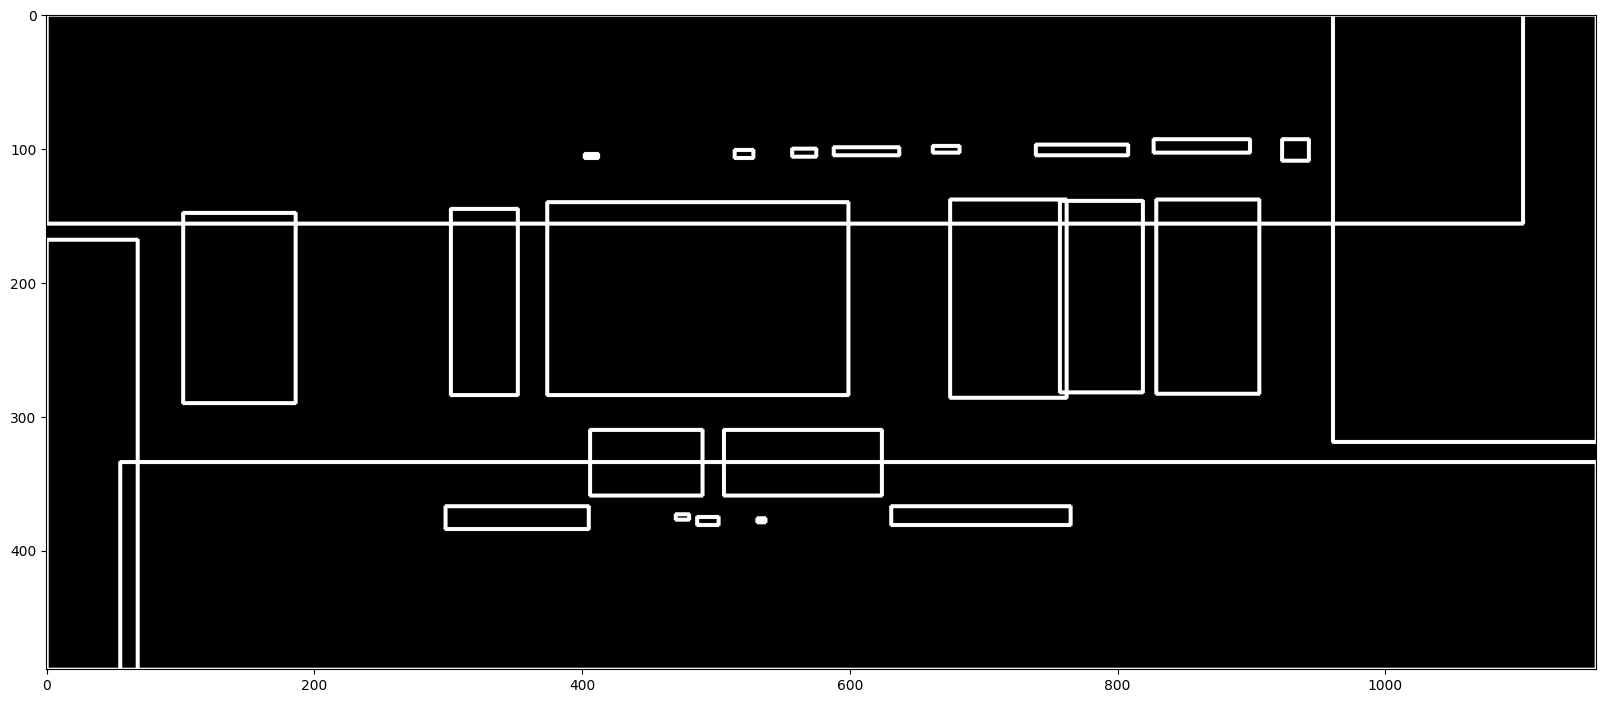

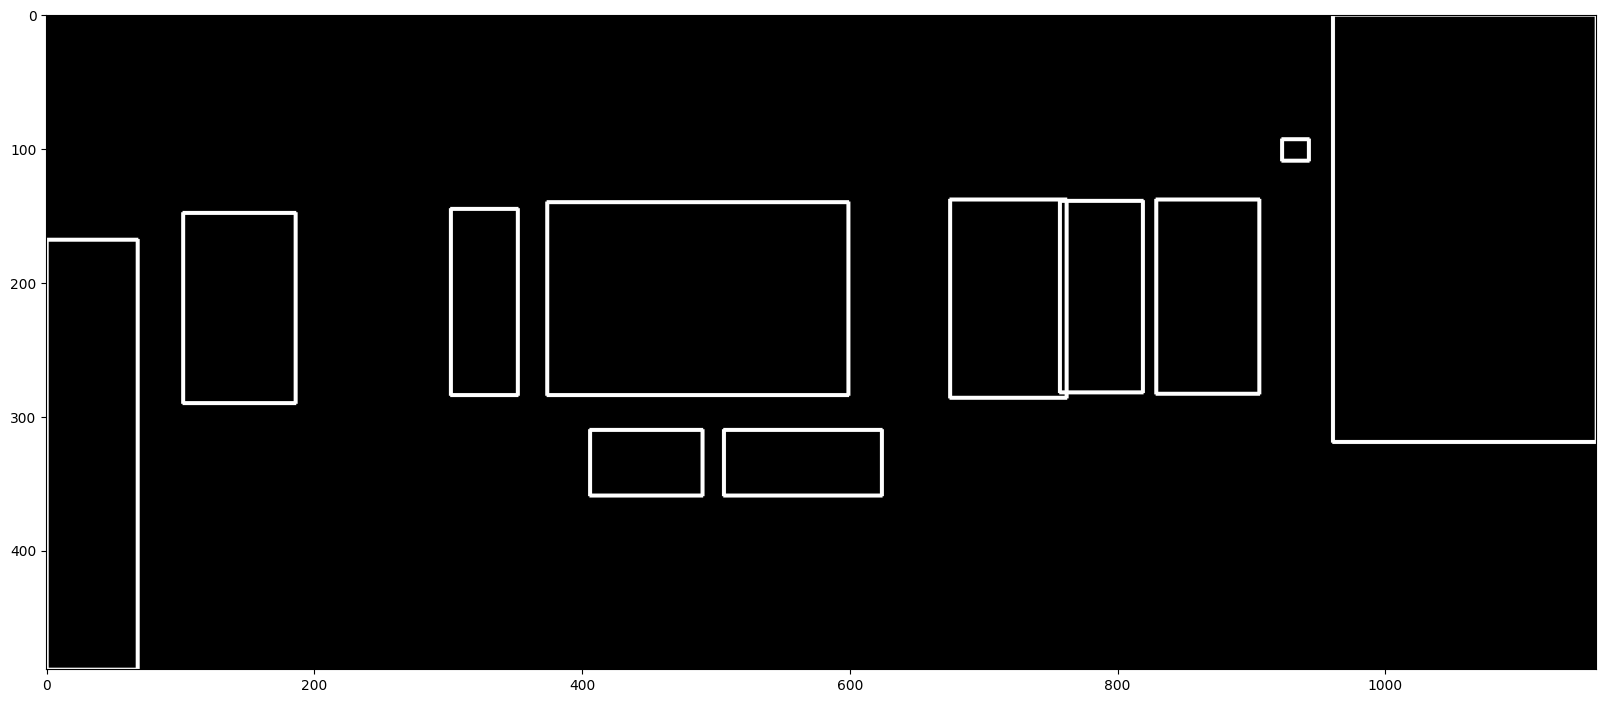

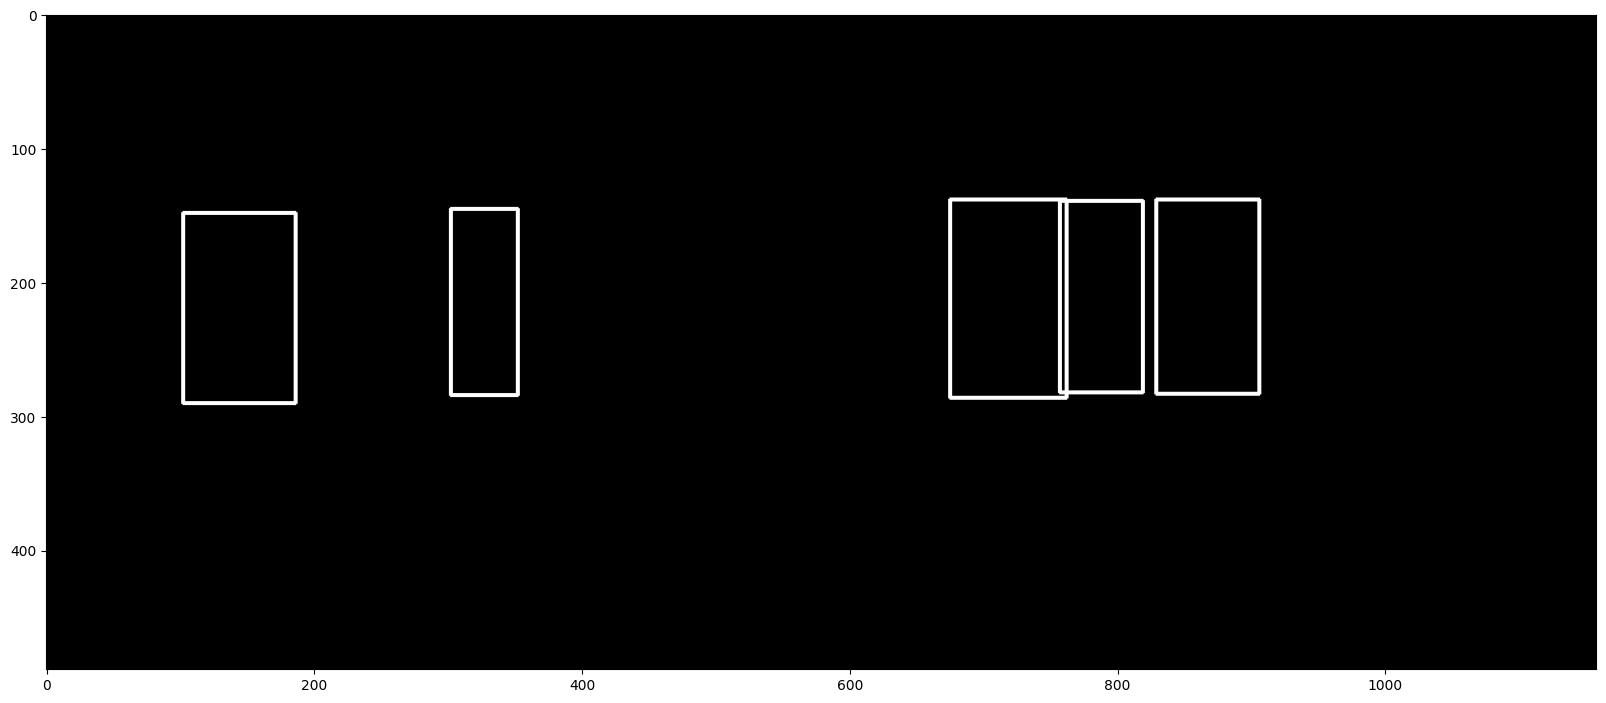

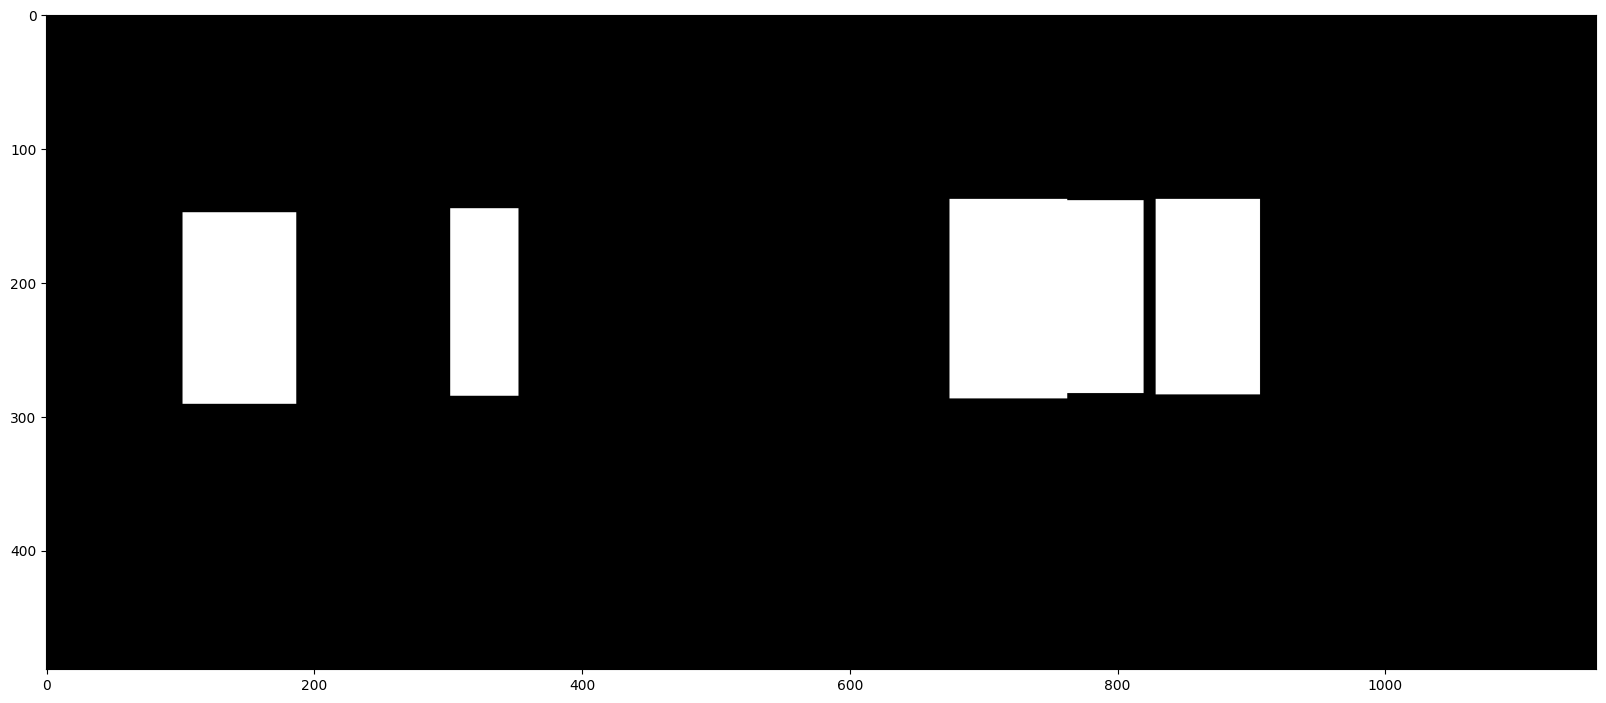

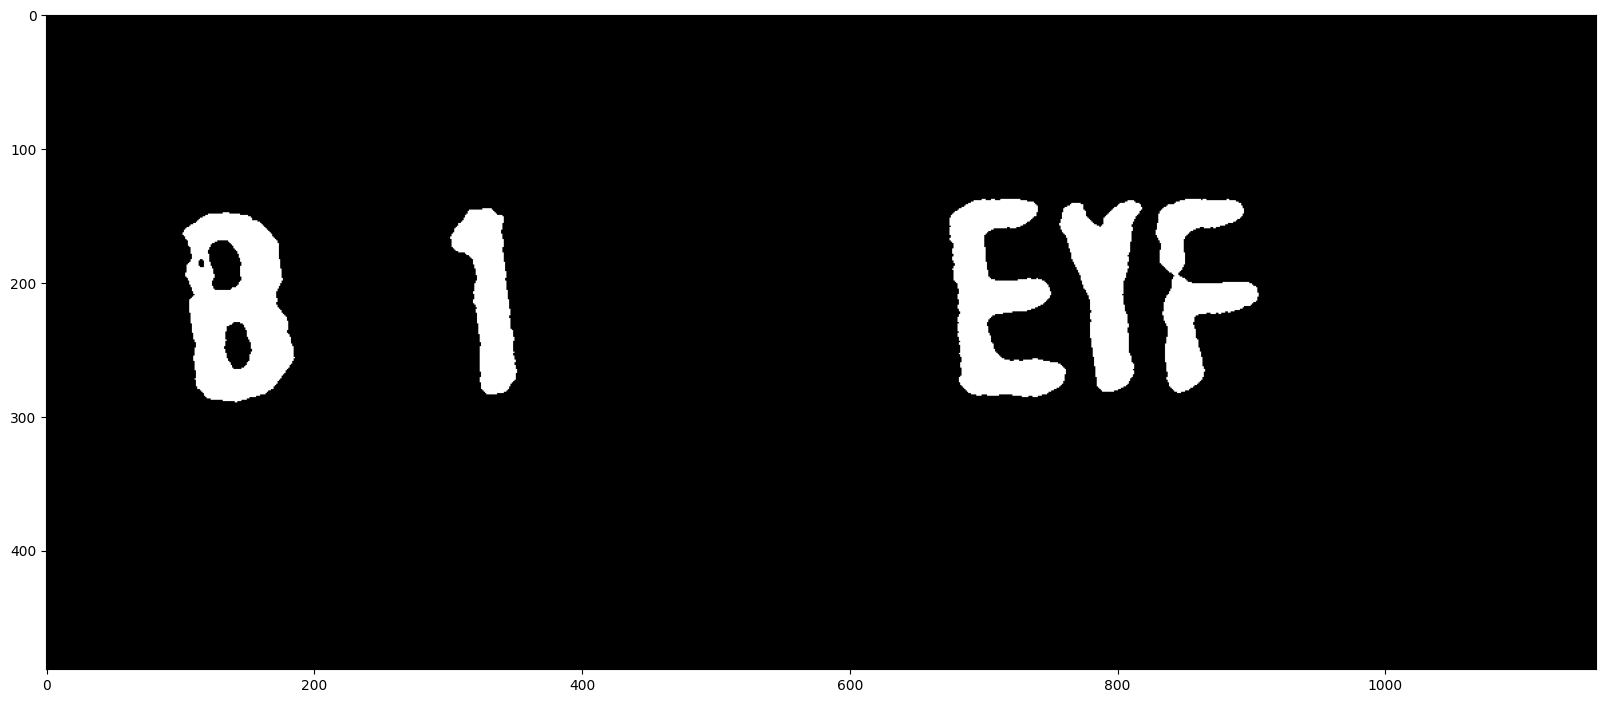

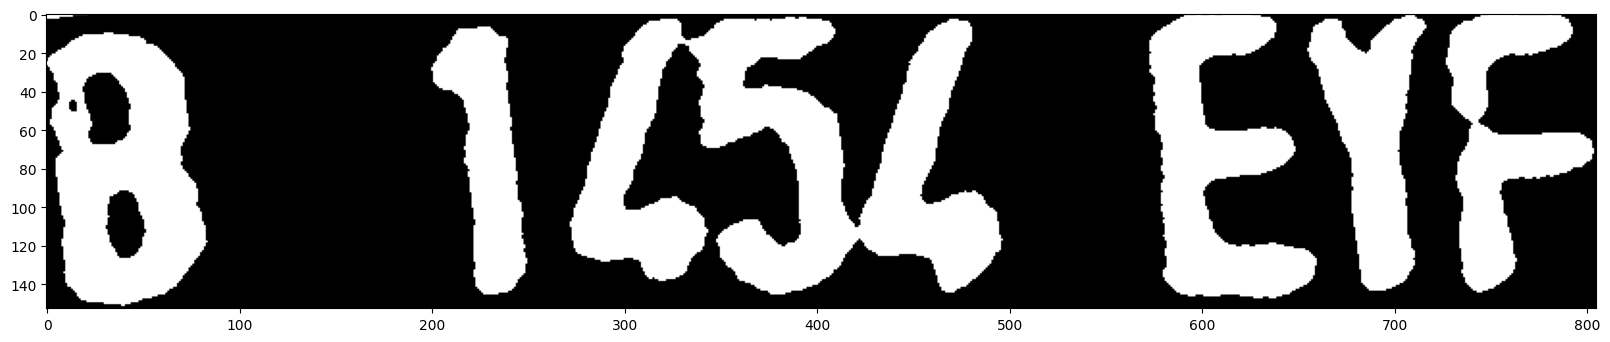

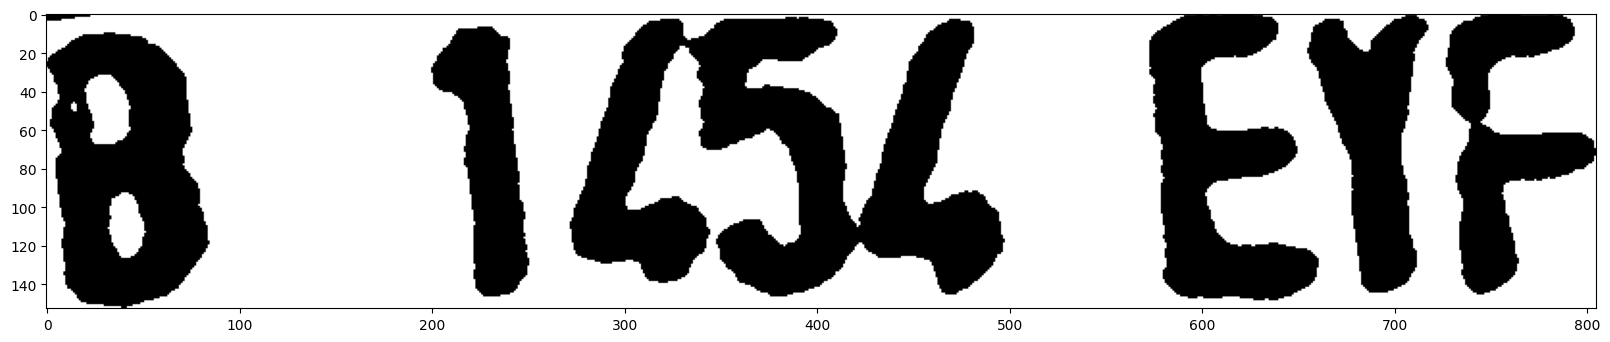

In [96]:
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu
from skimage.filters import threshold_triangle
from skimage.util import img_as_ubyte
test = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
test = get_grayscale(test)

test = resize(test)
test1 = threshold_otsu(test)
test = test > test1
test = img_as_ubyte(test)
test = puter(test)
test = bitwise(test)
# test = thr(test)

test = structuring(test)
test = sharpening(test)
test = denoise(test)
test = gaussian(test)
test = contour(test)
test = bitwise(test)
test = erode(test)
# test = dilate(test)

plt.figure(figsize=(20,30))
plt.imshow(test, cmap='gray')
plt.axis('on')
plt.show()


In [48]:
# from google.colab.patches import cv2_imshow
# img = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
# img = get_grayscale(img)
# img = remove_noise(img)
# # img = gabor(img)
# # img = structuring(img)
# img = resize(img)
# img = morph(img)
# # img = sharpening(img)
# # img = structuring(img)
# # img = contour(img)
# # img = Edge_detection(img)
# # img = thresholding(img)
# # img = dilate(img)
# # img = erode(img)
# # img = opening(img)
# # img = canny(img)
# plt.figure(figsize=(20,30))
# plt.imshow(img, cmap='gray')
# plt.axis('on')
# plt.show()



# Model

In [97]:
text = pt.image_to_string(test)
print(text)